In [1]:
# --- Imports ---
import os
import sys
import random
import pickle
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_partial_cartpole import CartPolePartialObservation
from actor_critic_song import ActorCriticAgent
from reinforce_song import train_agent
from helper_functions import plot_metrics, plot_firing_rates, load_model, save_model

# --- Set Random Seeds ---
seed_value = 1
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

2025-06-03 17:26:39.375457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748964399.397529   80490 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748964399.406004   80490 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748964399.447765   80490 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748964399.447785   80490 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748964399.447787   80490 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.


Configuration loaded:
  env_name: CartPole-v1
  noise_std: 0.001
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 5000
  gamma: 0.95
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating base environment: CartPole-v1
Wrapping base environment for partial observations (position, angle)
Observation size: 2, Action size: 2
Initializing Actor-Critic Agent...
Agent Initialized.
Starting training for 5000 episodes...
Episode 100	Total Reward: 22.00	State [-0.12184564  0.17688082]	Actor Loss: 0.3382	Critic Loss: 6.5642
Episode 200	Total Reward: 38.00	State [-0.02222103  0.2058344 ]	Actor Loss: 2.3819	Critic Loss: 24.1034
Episode 300	Total Reward: 57.00	State [-0.01545303 -0.19133137]	Actor Loss: 6.1760	Critic Loss: 98.5607
Episode 400	Total Reward: 18.00	State [ 0.12230471 -0.192359

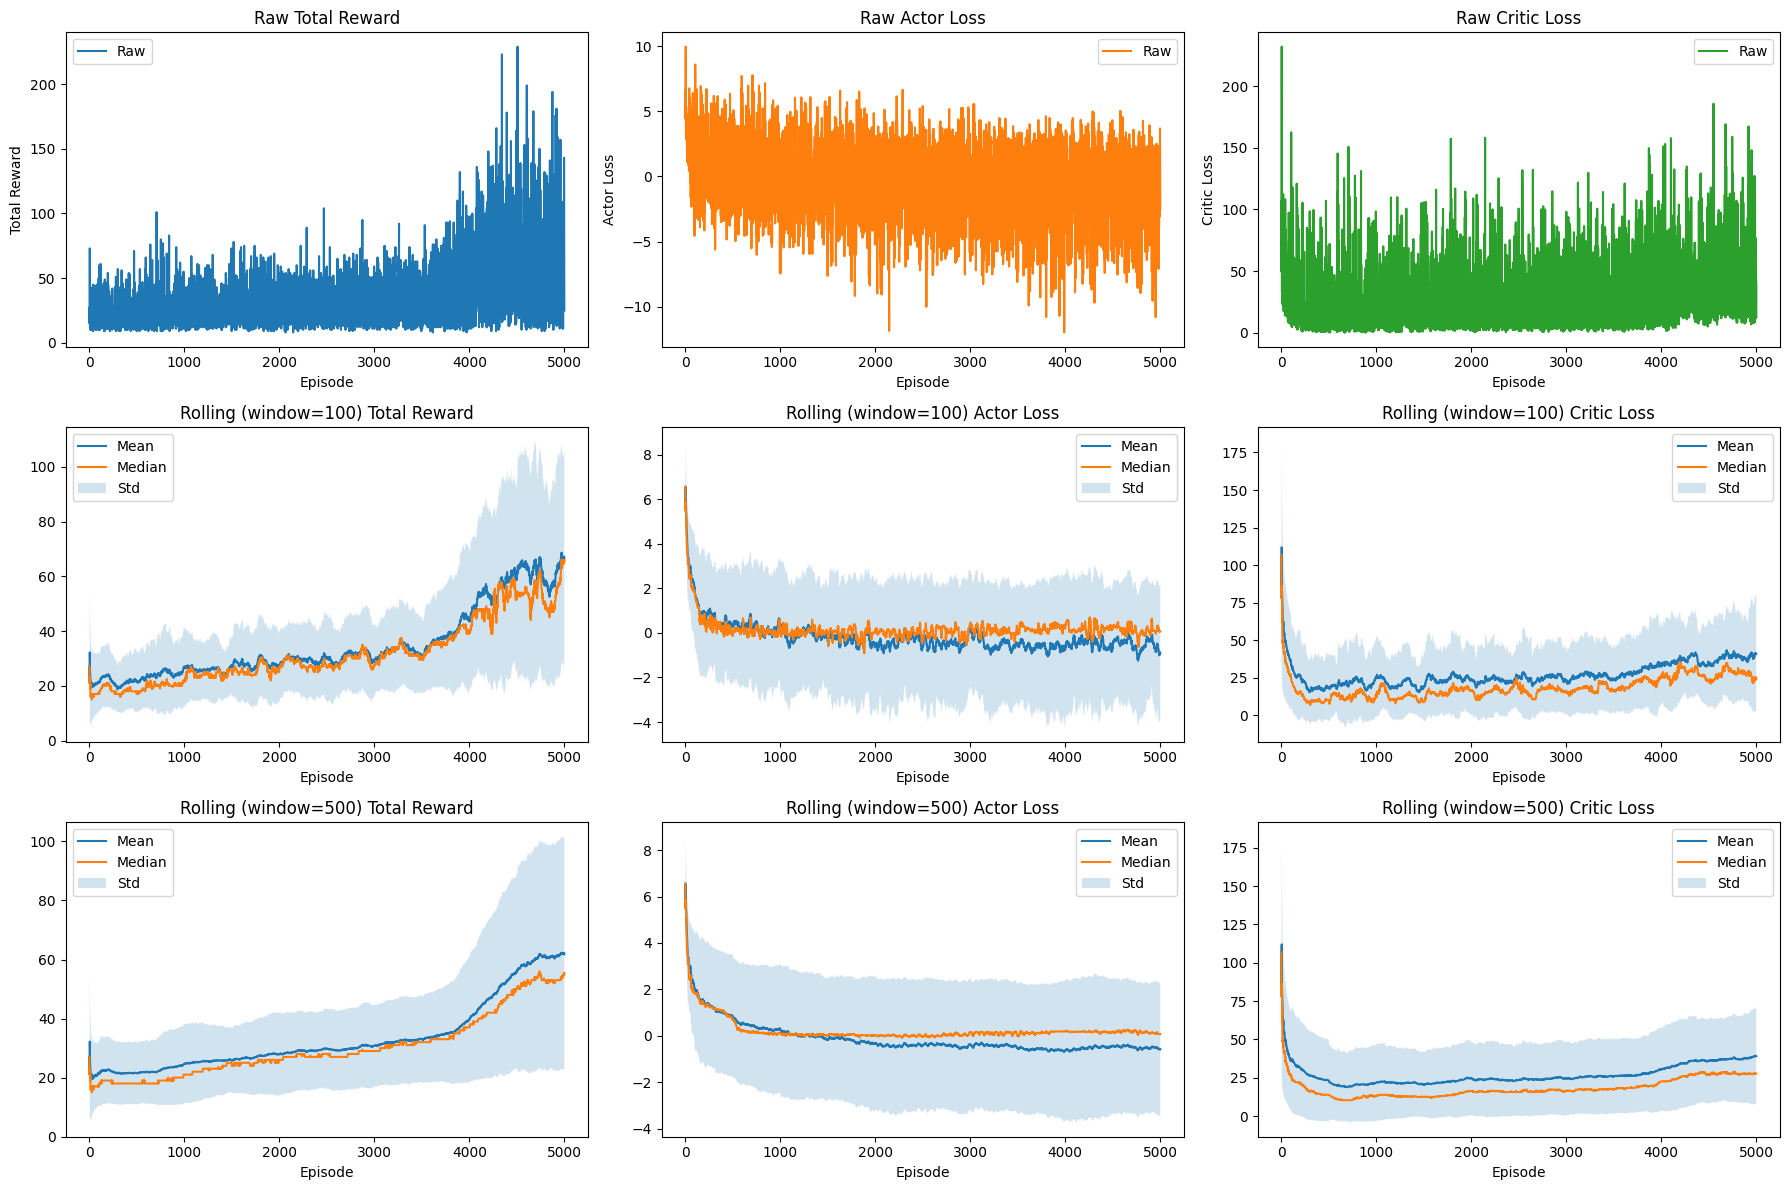

/content/Modules/helper_functions.py:536: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/content/Modules/helper_functions.py:537: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


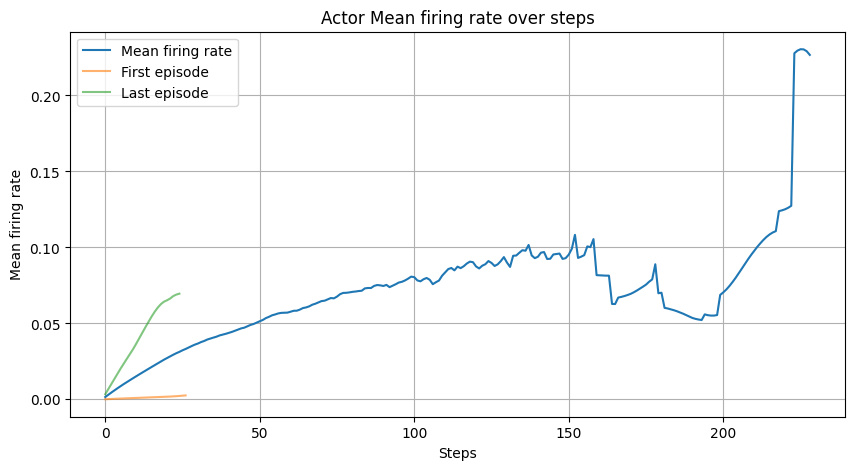

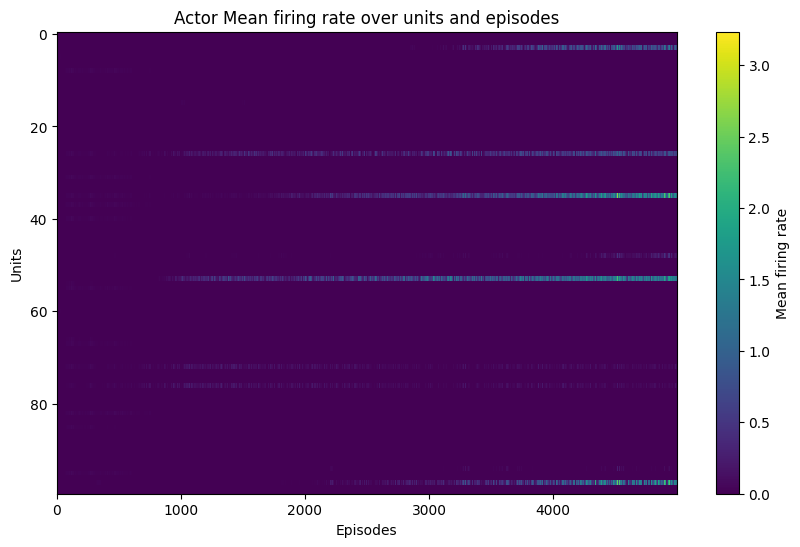

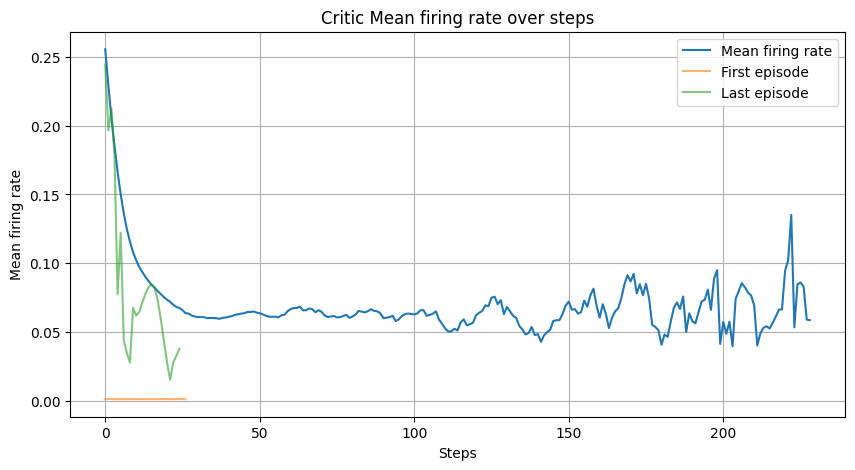

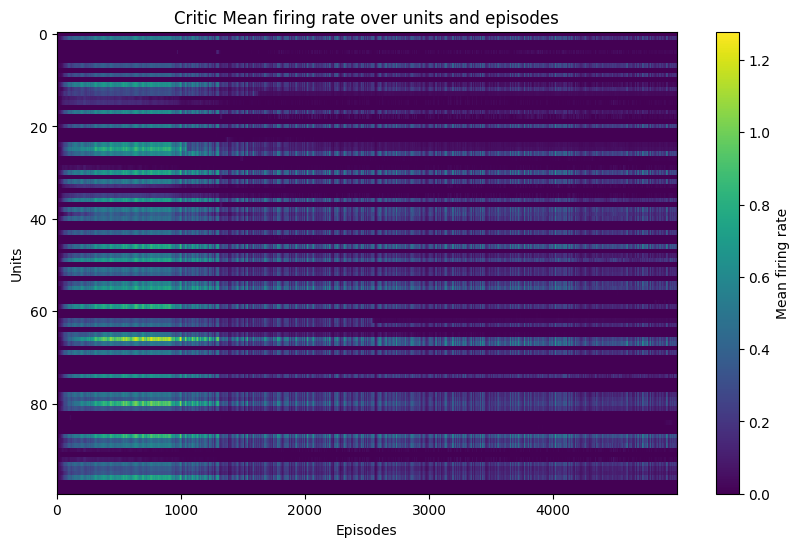

Closing environment...
Done.


In [3]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "env_name": "CartPole-v1",
        "noise_std": 0.001,
        # Agent architecture
        "actor_hidden_size": 100,
        "critic_hidden_size": 100,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 4e-3,
        "critic_lr": 4e-3,
        "num_episodes": 5000,
        "gamma": 0.95,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print(f"Creating base environment: {config['env_name']}")
    base_env = gym.make(config["env_name"])
    print("Wrapping base environment for partial observations (position, angle)")
    env = CartPolePartialObservation(base_env)

    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_coherences = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 1 finished.")

    # --- Save checkpoint ---
    this_stage = 1
    this_ckpt_dir = 'checkpoints/rnn_cartpole_partial'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_cartpole_partial.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_coherences
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )

    plot_firing_rates(actor_firing_rates, critic_firing_rates)

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")

if __name__ == '__main__':
    main()

Configuration loaded:
  env_name: CartPole-v1
  noise_std: 0.001
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 1000
  gamma: 0.95
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating base environment: CartPole-v1
Wrapping base environment for partial observations (position, angle)
Observation size: 2, Action size: 2
Initializing Actor-Critic Agent...


2025-06-02 23:13:49.060157: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 1...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_cartpole_partial_1/ckpt-1
Checkpoint restored successfully.
Starting training for 1000 episodes...
Episode 100	Total Reward: 89.00	State [-0.15397729 -0.20807843]	Actor Loss: -0.8089	Critic Loss: 15.9608
Episode 200	Total Reward: 28.00	State [-0.2585024   0.18809703]	Actor Loss: -0.6280	Critic Loss: 13.9401
Episode 300	Total Reward: 57.00	State [0.10676356 0.20189244]	Actor Loss: 1.1541	Critic Loss: 21.7809
Episode 400	Total Reward: 64.00	State [ 0.6589356  -0.19207552]	Actor Loss: 0.4604	Critic Loss: 12.1928
Episode 500	Total Reward: 31.00	State [-0.2687888   0.20769182]	Actor Loss: -2.1718	Critic Loss: 37.6444
Episode 600	Total Reward: 43.00	State [-0.1866791   0.18175705]	Actor Loss: -2.1194	Critic Loss: 23.09

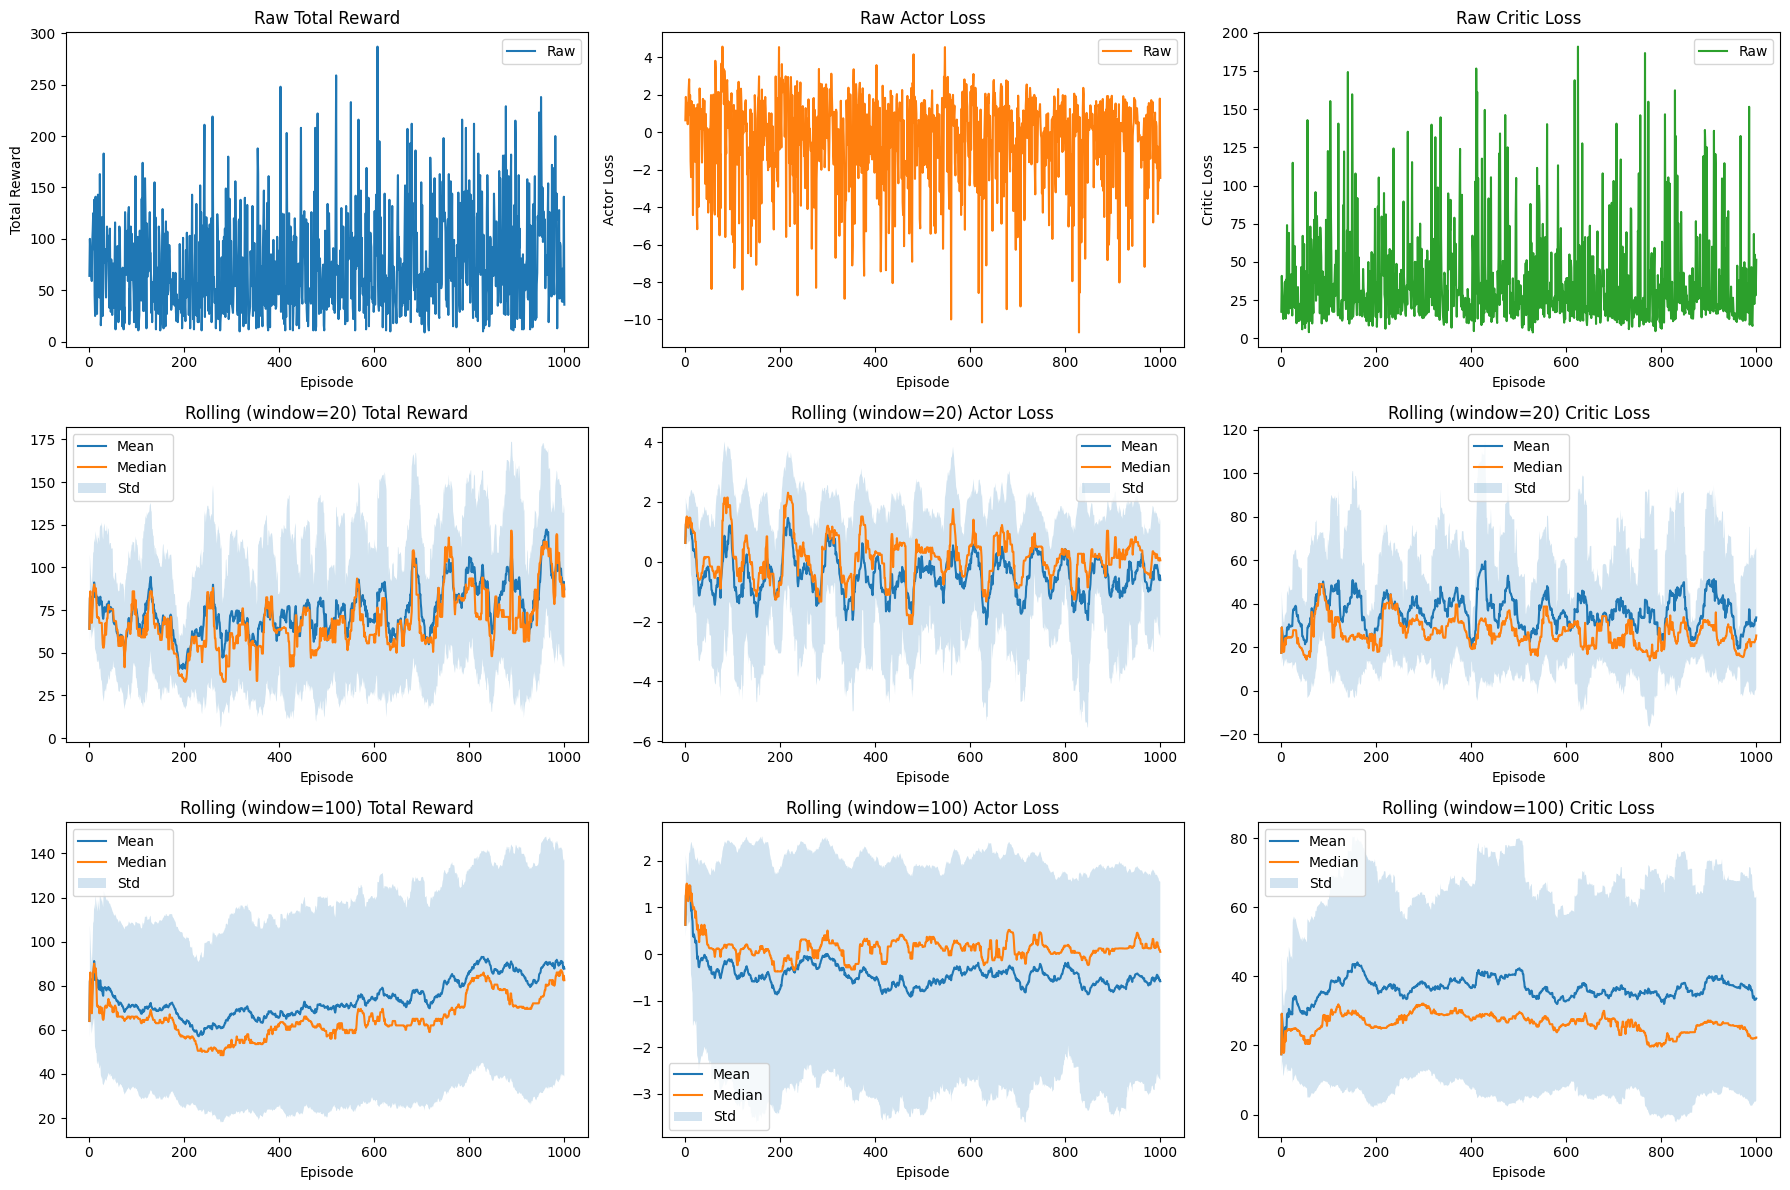

/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:536: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:537: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


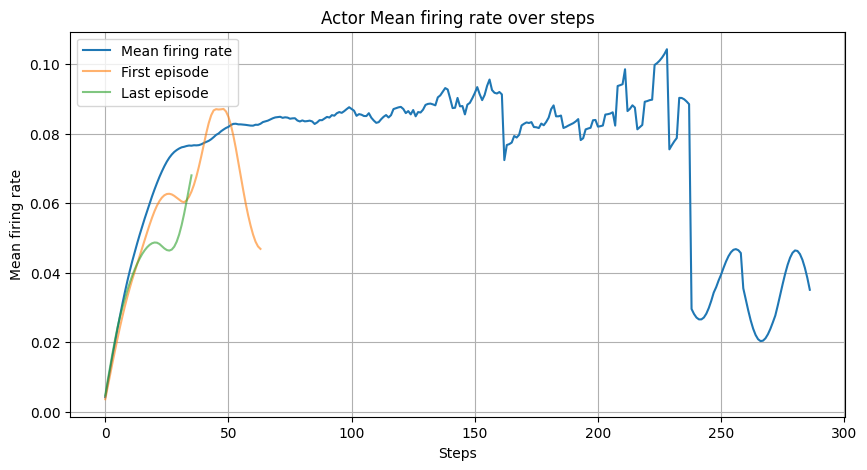

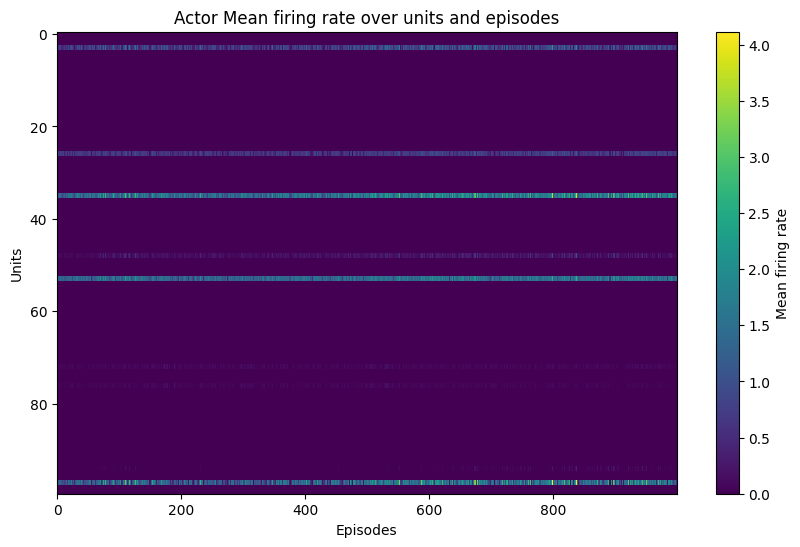

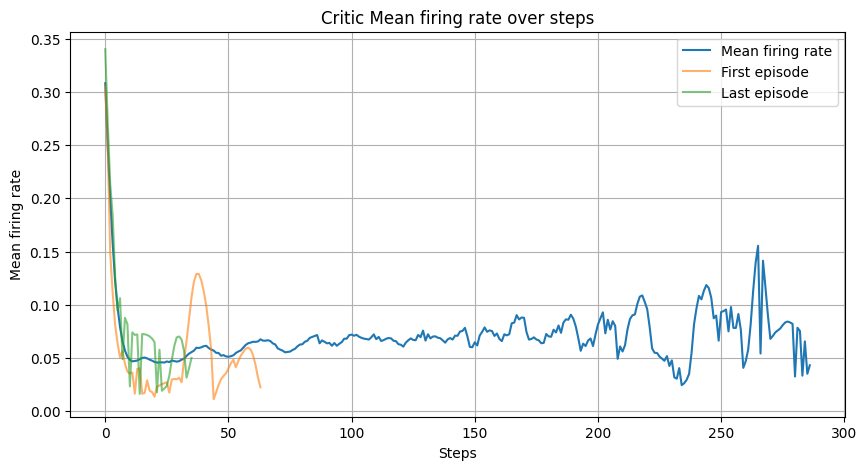

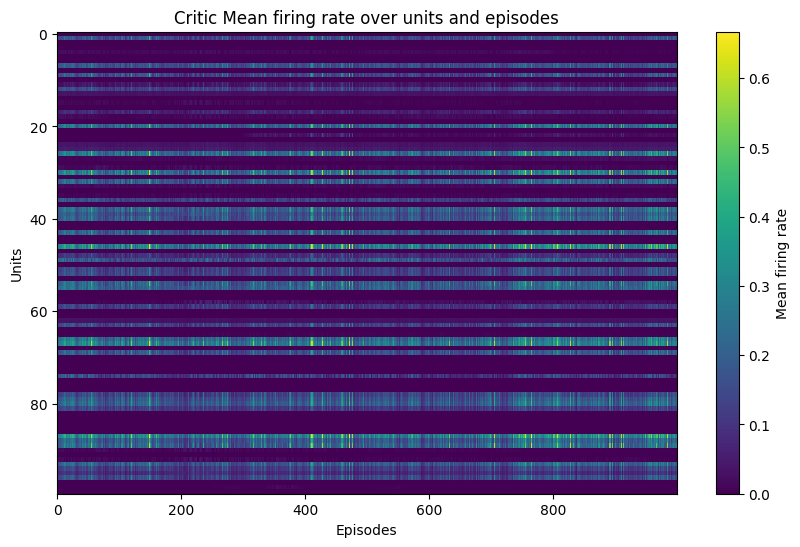

Closing environment...
Done.


In [2]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "env_name": "CartPole-v1",
        "noise_std": 0.001,
        # Agent architecture
        "actor_hidden_size": 100,
        "critic_hidden_size": 100,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 4e-3,
        "critic_lr": 4e-3,
        "num_episodes": 1000,
        "gamma": 0.95,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print(f"Creating base environment: {config['env_name']}")
    base_env = gym.make(config["env_name"])
    print("Wrapping base environment for partial observations (position, angle)")
    env = CartPolePartialObservation(base_env)

    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/rnn_cartpole_partial'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_coherences = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 2 finished.")

    # --- Save checkpoint ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/rnn_cartpole_partial'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_cartpole_partial_2.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_coherences
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )

    plot_firing_rates(actor_firing_rates, critic_firing_rates)

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")

if __name__ == '__main__':
    main()

In [ ]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "env_name": "CartPole-v1",
        "noise_std": 0.001,
        # Agent architecture
        "actor_hidden_size": 100,
        "critic_hidden_size": 100,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 4e-3,
        "critic_lr": 4e-3,
        "num_episodes": 1000,
        "gamma": 0.95,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 25,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print(f"Creating base environment: {config['env_name']}")
    base_env = gym.make(config["env_name"])
    print("Wrapping base environment for partial observations (position, angle)")
    env = CartPolePartialObservation(base_env)

    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 3
    this_ckpt_dir = 'checkpoints/rnn_cartpole_partial'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_coherences = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 3 finished.")

    # --- Save checkpoint ---
    this_stage = 3
    this_ckpt_dir = 'checkpoints/rnn_cartpole_partial'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_cartpole_partial_3.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_coherences
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )

    plot_firing_rates(actor_firing_rates, critic_firing_rates)

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")

if __name__ == '__main__':
    main()

Configuration loaded:
  env_name: CartPole-v1
  noise_std: 0.001
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 1000
  gamma: 0.95
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 25
  record_history: 1
Creating base environment: CartPole-v1
Wrapping base environment for partial observations (position, angle)
Observation size: 2, Action size: 2
Initializing Actor-Critic Agent...


2025-06-03 17:27:15.434070: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 2...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_cartpole_partial_2/ckpt-1
Checkpoint restored successfully.
Starting training for 1000 episodes...
Episode 25	Total Reward: 287.00	State [-1.4793766  -0.19527969]	Actor Loss: 3.2508	Critic Loss: 81.6642
Episode 50	Total Reward: 73.00	State [ 0.01906317 -0.19883558]	Actor Loss: -2.0467	Critic Loss: 31.7352
